# Loading the data
Make sure the CSV files provided by Zindi are in the same folder as this notebook. If it's running on Google Colab, you can use the 'files' tab on the left to upload them. We load the training data from Train.csv, and print out the variable descriptions here for easy reference. 

In [1]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('data/Train.csv')
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [3]:
# Only work with reduced number of features for the first iteration of model-building
# These features were found to be highly correlated to the target

reduced_feature_list = ['pw_00', 'psa_00', 'car_00', 'pg_03', 'NL', 'lan_00', 'pg_00', 'target']
df_red = df[reduced_feature_list]

In [4]:
df_red.shape

(2822, 8)

In [5]:
# transform the data --> all zeros should be a very small number
def convert_zeros(x):
    '''
    function to convert zeros to a positive number 
    so that it can be transformed with the boxcox'''
    if x == 0.0:
        return 0.0000001
    else :
        return x


In [6]:
# Apply our conversion of zeros to the reduced dataset

for col in reduced_feature_list:
    if col != 'target' and  col != 'psa_00' and col != 'car_00' and col != 'pg_00':
        df_red[col] = df_red[col].apply(convert_zeros)
        df_red[col] = boxcox(df_red[col])[0].reshape(-1,1);

In [7]:
df_red.head()

,pw_00,psa_00,car_00,pg_03,NL,lan_00,pg_00,target
0,-0.284113,0.260191,0.273727,-2.468668,-1.053425,-0.183226,0.357455,16.773757
1,-0.982978,0.290228,0.144638,-3.780784,1.361363,-0.128422,0.698428,21.496661
2,-0.951828,0.186435,0.272220,-1.716657,-3.789711,-0.573863,0.672452,10.931425
3,-0.366754,0.281229,0.127875,-5.967212,0.782549,-0.297017,0.728014,23.119257
4,-0.249689,0.196687,0.404507,-2.126300,-3.789711,-0.870200,0.753491,13.652252


In [8]:
# Train test split with same random seed
# Defining X and y
features = df_red.columns.tolist()
features.remove('target')
X = df[features]
y = df_red.target

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=150, shuffle=True)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (2116, 7)
y_train: (2116,)
X_test: (706, 7)
y_test: (706,)


In [9]:
# Build a multiple linear regression model with the data
lr = LinearRegression()
# fitting the training data
lr.fit(X_train,y_train)

LinearRegression()

In [10]:
# define the predictions:
y_pred_lin =  lr.predict(X_test)

In [37]:
lr.coef_

array([-5.13887081e+00,  7.38255444e+01, -2.84745915e+01,  1.03716048e+01,
       -4.06508867e-02, -1.11414677e+01, -9.99419243e+00])

In [11]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [12]:
# Evaluate the model (Multiple Linear Regression)

# predicting the model fit
score = r2_score(y_test,y_pred_lin)
print("r2 score is ", round(score, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred_lin), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred_lin)), 2))

r2 score is  0.81
mean_sqrd_error is: 19.32
root_mean_squared error is: 4.396


In [17]:
# Grid search for Linear Regression

# Defining parameter grid (as dictionary)
param_grid = {"fit_intercept" : [True, False],
              "normalize" : [True, False]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(LinearRegression(), param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit gridsearch object to data
gs.fit(X_train, y_train)

/Users/corinna/neuefische/urban-eureka/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/corinna/neuefische/urban-eureka/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous be

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [18]:
# Evaluate the model (Multiple Linear Regression) --> Grid search
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.821
Best parameters: {'fit_intercept': True, 'normalize': True}


In [20]:
y_pred_lin_gs = gs.predict(X_test)

In [21]:
# Evaluate the model (Multiple Linear Regression) (Grid Search)

# predicting the model fit
score_lin_gs = r2_score(y_test, y_pred_lin_gs)
print("r2 score is ", round(score_lin_gs, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred_lin_gs), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred_lin_gs)), 2))

r2 score is  0.81
mean_sqrd_error is: 19.32
root_mean_squared error is: 4.4


In [ ]:
# Linear Regression with 2nd degree Polynomial Features

poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
#y_train_poly = poly.fit_transform(y_train)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

In [ ]:
# Evaluate the model (2nd degree Polynomial)

# predicting the model fit
score_poly = r2_score(y_test, y_pred_poly)
print("r2 score is ", round(score_poly, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred_poly), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred_poly)), 2))

In [25]:
# Linear Regression with 2nd degree Polynomial Features with interactions

poly2 = PolynomialFeatures(2, interaction_only=True)
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.transform(X_test)
#y_train_poly = poly.fit_transform(y_train)

model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)
y_pred_poly2 = model_poly2.predict(X_test_poly2)

In [26]:
# Evaluate the model (2nd degree Polynomial with interactions)

# predicting the model fit
score_poly2 = r2_score(y_test, y_pred_poly2)
print("r2 score is ", round(score_poly2, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred_poly2), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred_poly2)), 2))

r2 score is  0.83
mean_sqrd_error is: 17.96
root_mean_squared error is: 4.24


In [22]:
# Grid search for Polynomial Regression
poly2 = PolynomialFeatures(2, interaction_only=True)
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.transform(X_test)


# Defining parameter grid (as dictionary)
param_grid = {"fit_intercept" : [True, False],
              "normalize" : [True, False]
             }

# Instantiate gridsearch and define the metric to optimize 
gs_poly = GridSearchCV(LinearRegression(), param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit gridsearch object to data
gs_poly.fit(X_train_poly2, y_train)

/Users/corinna/neuefische/urban-eureka/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/corinna/neuefische/urban-eureka/.venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous be

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [23]:
# Evaluate the model (Multiple Linear Regression) --> Grid search
# Best score
print('Best score:', round(gs_poly.best_score_, 3))

# Best parameters
print('Best parameters:', gs_poly.best_params_)

Best score: 0.837
Best parameters: {'fit_intercept': False, 'normalize': True}


In [24]:
y_pred_poly_gs = gs_poly.predict(X_test_poly2)

# Evaluate the model (2nd degree Polynomial with interactions)

# predicting the model fit
score_poly2_gs = r2_score(y_test, y_pred_poly_gs)
print("r2 score is ", round(score_poly2_gs, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred_poly_gs), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred_poly_gs)), 2))

r2 score is  0.83
mean_sqrd_error is: 17.64
root_mean_squared error is: 4.2


In [ ]:
# Linear Regression with 3rd degree Polynomial Features

poly3 = PolynomialFeatures(3)
X_train_poly3 = poly3.fit_transform(X_train)
X_test_poly3 = poly3.transform(X_test)
#y_train_poly = poly.fit_transform(y_train)

model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)
y_pred_poly3 = model_poly3.predict(X_test_poly3)

In [ ]:
# Evaluate the model (3rd degree Polynomial)

# predicting the model fit
score_poly3 = r2_score(y_test, y_pred_poly3)
print("r2 score is ", round(score_poly3, 2))
print("mean_sqrd_error is:", round(mean_squared_error(y_test, y_pred_poly3), 2))
print("root_mean_squared error is:", round(np.sqrt(mean_squared_error(y_test, y_pred_poly3)), 2))

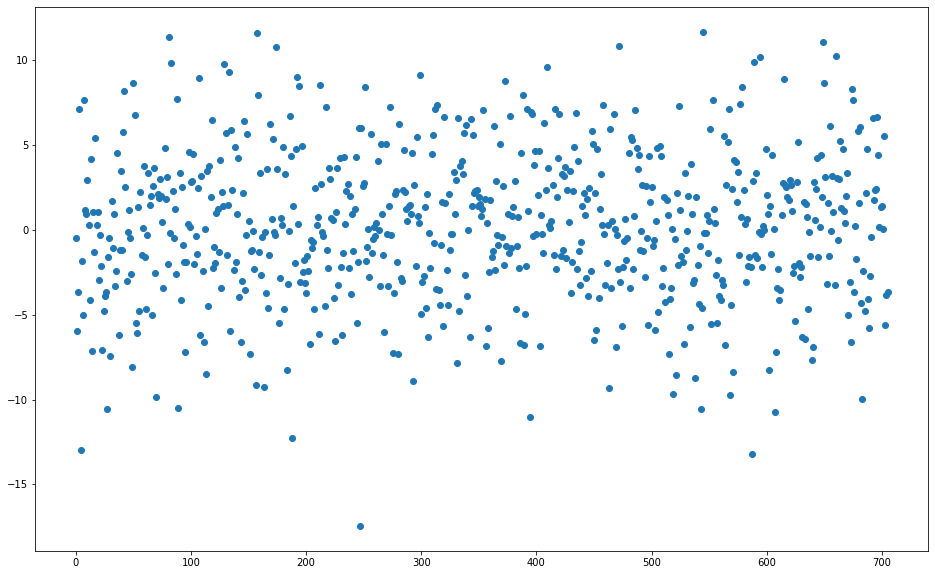

In [36]:
# plotting the errors

plt.scatter(np.arange(len(y_test)), (y_pred_lin-y_test))